In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, pystan as ps, arviz
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

#### Generate data:

In [3]:
n_in = 1
n_out = 2

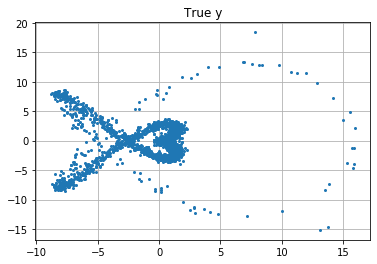

In [6]:
error_sigma2 = 0.1
Nobs = 2_000
X = torch.randn(Nobs, n_in, requires_grad=True)
X = X.data
Y = np.zeros((Nobs, n_out))
Y[:,0] = list(abs(X)*np.cos(2*X))
Y[:,1] = list(abs(X)*np.sin(3*X))
Y = 5*torch.from_numpy(Y).float() + torch.randn(Nobs,2)*np.sqrt(error_sigma2)
criterion = nn.MSELoss()
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

### Testing tying down reference points:

#### Compile Stan function:

In [2]:
sm = ps.StanModel(file="nn_refpoints.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d854d55d55579dd7aff2ba075427031 NOW.


In [14]:
n_ref = 200
ref = npr.choice(Nobs,n_ref,replace=False)
train = np.setdiff1d(np.arange(Nobs), ref)
y_ref = Y[ref]
X_ref = X[ref].detach().numpy()

In [15]:
data = dict(Nobs=Nobs, 
            in_dim=n_in, 
            out_dim=n_out, 
            hidden_dim_1=100,
            n_ref=n_ref,
            y=Y[train].detach().numpy(), 
            y_ref=y_ref,
            X_ref=X_ref)

In [16]:
control = dict(adapt_delta=0.9, max_treedepth=12)
fit = sm.sampling(data=data, thin=10, n_jobs=4, init="random", iter=1_000, control=control)
print(fit);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_27b2700f192a9f8350d50003e91a09cd.
4 chains, each with iter=1000; warmup=500; thin=10; 
post-warmup draws per chain=50, total post-warmup draws=200.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]             0.11    0.05   0.11  -0.16    0.1   0.15   0.18   0.25      5   1.44
X[2,1]             -0.2    0.33   0.47  -0.99  -0.64  -0.02   0.16   0.23      2   5.54
X[3,1]            -0.73     0.1   0.15  -0.89  -0.88  -0.73  -0.58  -0.52      2   5.46
X[4,1]            -0.06    0.03   0.09  -0.18  -0.12  -0.09 5.5e-3   0.13      7   1.24
X[5,1]          -3.6e-3    0.03   0.09  -0.19  -0.08 3.0e-3   0.08   0.13      9   1.23
X[6,1]             0.85 10.0e-3   0.05   0.66   0.85   0.86   0.87   0.89     28   1.09
X[7,1]            -0.63  7.4e-3   0.06  -0.85  -0.65  -0.62   -0.6  -0.55     73   1.05
X[8,1]            -0.67  5.3e-3   0.06  -0.84   -0.7  -0.66  -0.62  -0.58    132   1.02
X[9,1]            -0.6

In [17]:
(fit.get_sampler_params())

[OrderedDict([('accept_stat__',
               array([1.        , 0.98651153, 0.8527644 , 0.98124408, 0.67866148,
                      0.8836947 , 0.95658484, 0.93148106, 0.9979356 , 0.83499963,
                      0.61729537, 0.54782966, 0.99998586, 0.9966576 , 0.48491236,
                      0.72782226, 0.96923985, 0.9927452 , 0.42521755, 0.64000726,
                      0.98535496, 0.6147362 , 0.97658378, 0.96473267, 0.81018932,
                      0.23711787, 0.67229436, 0.97376723, 0.97802272, 0.9932648 ,
                      0.96673345, 0.92741845, 0.91388698, 0.83781688, 0.97710066,
                      0.99210194, 0.98433017, 0.97128974, 0.9668185 , 0.8802869 ,
                      0.96222396, 0.92776428, 0.5182412 , 0.83911958, 0.85551126,
                      0.05735211, 0.82163658, 0.55754273, 0.91874895, 0.99619159,
                      0.9493189 , 0.86413807, 0.99033951, 0.94177273, 0.86614717,
                      0.97661765, 0.99631843, 0.87171349, 0.999142

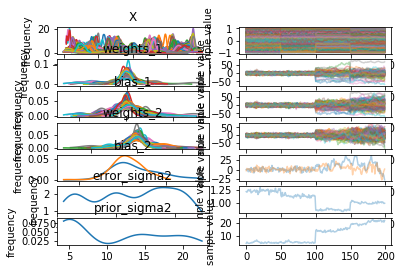

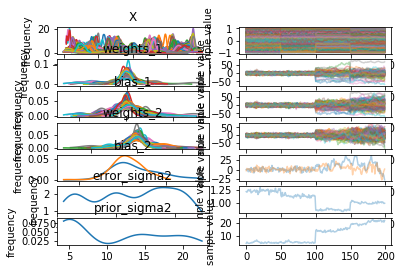

In [18]:
fit.plot()

In [9]:
trace = fit.extract()

In [10]:
y_pred = np.matmul(np.tanh(Xtrue.detach().numpy()*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 

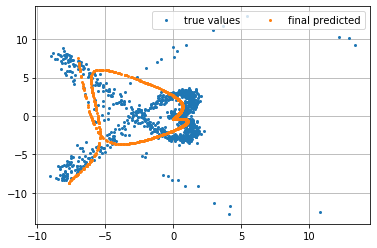

In [12]:
plt.plot(list(Ytrue[:,0]), list(Ytrue[:,1]), 'o', markersize=2, label="true values")
plt.plot(y_pred[:,0],y_pred[:,1], 'o', markersize=2, label="final predicted")
plt.grid(True)
plt.legend(ncol=2)

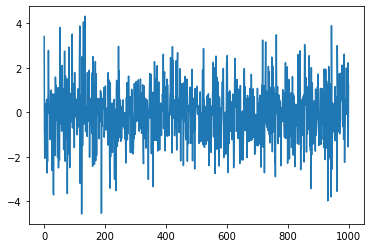

In [15]:
plt.plot(trace['weights_1'][:,0,2])

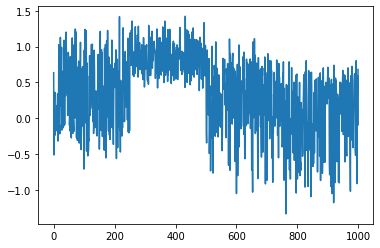

In [21]:
plt.plot(trace['X'][:,3])

### Testing GP prior for latent $X$:

In [ ]:
sm = ps.StanModel(file="nn_GPprior.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e7e0bfb298f46865225bb5108c36029 NOW.
